In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from off_pol_eval_functions import * 
from matplotlib import cm
from __future__ import division
from scipy import interpolate
from mpl_toolkits.mplot3d import Axes3D

n = 500
m = 10
d= 1
t_lo = 0
t_hi = 1


/Users/az/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/az/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Data generation & configuration

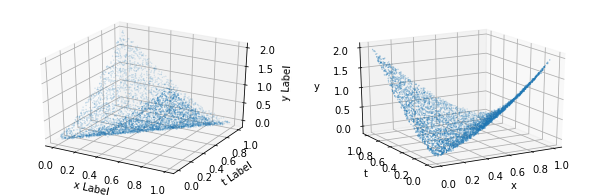

In [9]:
def generate_data_moving_parabolas(m,n, d, t_lo, t_hi): 
    xs = np.array(np.random.uniform(0,1,(n*m,d)))
    if t_lo < -10: 
        t_lo = -10
    if t_hi > 10: 
        t_hi = 10
    Ts = np.array(np.random.uniform(t_lo,t_hi, (n*m,d))) 
    Z = np.concatenate([xs,Ts], axis = 1)
    # mean_vec = np.asarray([ np.mean(z) for z in Z])
    F = np.zeros([m*n,1])
    for i in np.arange(m*n): 
        F[i] = 2*pow(np.abs(xs[i] - Ts[i]),1.5)
# Ensure outcomes are positive
    if min(F) < 0:
        F = F + abs(min(F))  
    Y = F + 0.02*np.random.randn(m*n,1)
    return { 'y': Y, 'z': Z, 'f': F , 'x': xs}

def oracle_evaluation(**params): 
    X = params['x_samp']; tau = params['tau']
    return 2*pow(np.abs(X - tau),1.5)

data = generate_data_moving_parabolas(m,n, d, t_lo, t_hi)
# data = generate_data_uniform(m,n, d, t_lo, t_hi, x_scheme = 'unif')
sub_params = { 'n': n, 'y': data['y'],'f': data['f'], 'x': data['x'],'d': d, 'T': data['z'][:,d], 'z': data['z'], 'm': m, 'h': 0.001, 'Q': unif_Q , 't_lo': t_lo ,'t_hi': t_hi  }

# output = open('data_exp' + str(datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")) + '.pkl', 'wb')
# pickle.dump(sub_params, output)
# output.close()

# sub_params['Q'] = exp_Q
sub_params['Q'] = trunc_norm_Q 
sub_params['sampling'] = "truncated_normal"
sub_params['h'] = 0.15
plot_surface(**sub_params)

# Set Kernel Function (and integral) 
sub_params['kernel_func'] = epanechnikov_kernel
sub_params['kernel_int_func'] = epanechnikov_int

# Set Oracle Function Structure (known or intepolated? )
sub_params['oracle_func'] = oracle_evaluation
# sub_params['oracle_func'] =  evaluate_oracle_interpolated_outcomes

#Set data generation scheme (grid of values or uniformly sampled?)
sub_params['data_gen'] = "uniform"
sub_params['threshold'] = 0.02
# bandwidth_selection(200, 10, **sub_params)

spl_x = sub_params['z'][:,0]
spl_t = sub_params['z'][:,1]
# f is positive
splined_f_tck = interpolate.bisplrep(spl_x,spl_t, sub_params['f'])
sub_params['spline'] = splined_f_tck

### Discrete off-policy evaluation baseline: 

Off-policy evaluation is conducted by discretizing the treatment variable into some number of bins (to start off with, bins of uniform width). Policy evaluation consists of combining rejection and importance sampling to use datapoints where the target policy on $x_i$ matches the logging policy in assigned treatment 'bin'. Outcomes are weighted by propensity to assign the treatment (tentatively, the propensity score for the continuous treatment). 

# Testing constant off-policy evaluation

In [10]:
n_trials = 20
n_treatments = 20
n_spacing = 3
n_0 = 100
sub_params['n_bins'] = 10
n_max = 500
sub_params['h'] = 0.15
sub_params['sampling'] = "truncated_normal"

def zero_to_nan(values):
    """Replace every 0 with 'nan' and return a copy."""
    return np.array([float('nan') if x==0 else x for x in values])

[oracle_evals, off_pol_evals, off_pol_disc_evals] = off_pol_eval_cons_test(n_max, n_trials, n_treatments, n_spacing, n_0, t_lo,t_hi, check_alpha = True,  **sub_params)
off_pol_disc_evals[off_pol_disc_evals == 0 ] = np.nan

plot_off_pol_evals(off_pol_evals, oracle_evals, off_pol_disc_evals, n_0, n_max, n_trials, n_treatments, n_spacing, t_lo, t_hi, "constant treatment values", "Constant Policy Evaluations vs true counterfactual policy evaluations (truncated y)", truncate_y = 1.2 )


testing with n = 100


TypeError: 'numpy.float64' object cannot be interpreted as an index

## Off-policy evaluation for linear treatment policy

In [4]:
beta_hi = t_hi/max(sub_params['x'])
n_trials = 20
sub_params['n_bins'] = 10
n_treatments = 20
n_spacing = 3
n_0 = 100
n_max = 500
sub_params['h'] = 0.1

[lin_oracle_evals, lin_off_pol_evals, off_pol_disc_evals] = off_pol_eval_linear_test( n_max, 0, beta_hi, n_trials, n_treatments, n_spacing, n_0, check_alpha = True, **sub_params)
off_pol_disc_evals[off_pol_disc_evals == 0 ] = np.nan


plot_off_pol_evals(lin_off_pol_evals, lin_oracle_evals, off_pol_disc_evals, n_0, n, n_trials, n_treatments, n_spacing, 0, beta_hi, "beta values", "Linear Policy Evaluations vs true counterfactual policy evaluations",truncate_y = 1.5)

testing n = 100


KeyError: 'threshold'

In [5]:
plot_off_pol_evals(lin_off_pol_evals, lin_oracle_evals, off_pol_disc_evals, n_0, n, n_trials, n_treatments, n_spacing, 0, beta_hi, "beta values", "Linear Policy Evaluations vs true counterfactual policy evaluations",truncate_y = 5)

NameError: name 'lin_off_pol_evals' is not defined

In [6]:
# print np.abs(np.mean(off_pol_evals,axis = 2)  - np.mean(oracle_evals, axis =2 ))
print "Percent errors: "
print (np.abs(np.mean(off_pol_evals,axis = 2)  - np.mean(oracle_evals, axis =2 ))) / np.mean(oracle_evals, axis =2 ) 

Percent errors: 


NameError: name 'off_pol_evals' is not defined

In [7]:
n_sub = 200
subsamples_pm = evaluate_subsample( n_sub, evaluation = False, cross_val = False, **sub_params )
# treatment_overlap = np.where(np.equal(tau_vec.flatten(), T_binned.flatten()))[0]

T = subsamples_pm['T_samp']
n_bins = 10
bin_width = t_hi-t_lo
bins = np.linspace(t_lo, t_hi, n_bins)
T_binned = np.digitize(T, bins)
bin_means = [T[T_binned == i].mean() for i in range(1, len(bins))]

print len(bins)
print T_binned.shape
print len(bin_means)
ind = 0 
for i in np.arange(len(T)): 
    print bin_means[T_binned[i]-1]

10
(200, 1)
9


TypeError: only integer scalar arrays can be converted to a scalar index

# Optimizing for best linear treatment policy 

In [8]:
''' Test policy optimization routine '''
from scipy.optimize import minimize
from sklearn.grid_search import GridSearchCV


# Construct new data dictionary with sampled treatment values
# samp_params = evaluate_subsample(n, cv_func = CV_gaussian, **sub_params)

# bandwidths = {'bandwidth': np.logspace( np.power(n, -0.2) * 0.1, np.power(n, -0.2) * 10,20)}
# grid = GridSearchCV(KernelDensity(), bandwidths)
# test_data = np.concatenate([sub_params['x'].reshape([n,1]), sub_params['T_samp'].reshape([n,1])],axis=1)
# grid.fit(test_data) 
# print "best bandwidth for f_t,x: {0}".format(grid.best_estimator_.bandwidth)

h = sub_params['h']

samp_params = evaluate_subsample( n, evaluation = False, cross_val = False, **sub_params )
# samp_params['T'] = sub_params['z'][:,1]
# Center losses
samp_params['y'] = samp_params['y'] - np.mean(samp_params['y'])
samp_params['f'] = samp_params['f'] - np.mean(samp_params['f'])
samp_params['y_samp'] = samp_params['y_samp'] - np.mean(samp_params['y_samp'])
samp_params['f_samp'] = samp_params['f_samp'] - np.mean(samp_params['f_samp'])
n_restarts = 6
oracle_betas = np.zeros([n_restarts, d])
eval_vals = np.zeros([n_restarts, d])
emp_betas = np.zeros([n_restarts, d])
emp_eval_vals = np.zeros([n_restarts, d])
for i in np.arange(n_restarts):
    [res, oracle_res, spline_f_tck] = pol_opt(verbose = False, **samp_params)
    print 'empirical beta' 
#     print res
    print res.x 
    print 'empirical est value'
    print res.fun
    emp_betas[i] = res.x
    emp_eval_vals[i] = res.fun

    print 'beta' 
    print oracle_res.x
    oracle_betas[i] = oracle_res.x
    print 'oracle best linear treatment policy value'
    print oracle_res.fun
    eval_vals[i] = oracle_res.fun
    
best_ind = np.argmin(eval_vals)
print 'oracle best linear treatment policy value'
print eval_vals[best_ind]
print 'oracle best beta' 
print oracle_betas[best_ind]
    
params_neg_y = samp_params
params_neg_y['spline'] = spline_f_tck
grid_vals = 20
vals = np.zeros(grid_vals)
beta_max = t_hi*1.0/np.mean(samp_params['x']) 
for ind,b in enumerate(np.linspace(0.02,beta_max,grid_vals)): 
    params_neg_y['tau'] = np.clip(np.dot( samp_params['x_samp'], b ) , t_lo, t_hi)
    val = oracle_evaluation(**params_neg_y)
    vals[ind] = np.mean(val)
plt.xlabel('beta')
plt.ylabel('average interpolated oracle outcome')

plt.scatter(np.linspace(0.02,beta_max,grid_vals), vals)
plt.plot(emp_betas, emp_eval_vals, 'ro')
plt.plot(oracle_betas, eval_vals, 'go')


KeyError: 'threshold'

# Optimizing for best constant treatment

In [ ]:
''' Test policy optimization routine '''
[res, oracle_res, spline_f_tck] = pol_opt(verbose = False, samp_func = constant_off_policy_loss_evaluation, oracle_func = eval_const_interpolated_oracle_tau, **samp_params)

params_neg_y = samp_params
grid_vals = 20
vals = np.zeros(grid_vals)
for ind,b in enumerate(np.linspace(0.02,1,grid_vals)): 
    beta = [b]
    val = eval_const_interpolated_oracle_tau(beta, params_neg_y.items())
    vals[ind] = val
plt.xlabel('beta')
plt.ylabel('average interpolated oracle outcome')
plt.plot(np.linspace(0.02,1,grid_vals), vals)
plt.plot(res.x, res.fun, 'ro')
plt.plot(oracle_res.x,oracle_res.fun, 'go')